#### Path to local libraries

In [1]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Import libraries

In [2]:
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import numpy as np
import math

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

import pmdarima as pm
from pmdarima import auto_arima

import plotly.io as pio

In [3]:
# Comment this line to render plotly into GitHub 
#pio.renderers.default = "svg"

In [4]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
country = 'DEN'

# Dependant variable (Orders or TIV)
dep_var = 'TIV'  

# Use feature eng/selection
feature_selection = True
include_nordics = True

### Load data

In [5]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date")
df.index = pd.PeriodIndex(df.index, freq="M")

In [6]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01,161,2.184,4.100,3.311,65.641
2006-02,250,2.163,4.200,3.484,61.924
2006-03,468,1.912,4.200,3.704,83.479
2006-04,412,1.902,4.200,3.975,77.673
2006-05,550,2.021,4.100,4.022,91.928
...,...,...,...,...,...
2022-08,343,8.910,4.500,1.375,74.473
2022-09,337,10.019,4.600,2.200,75.797
2022-10,322,10.112,4.600,2.599,63.243


In [7]:
if include_nordics:
    # Load files into a pandas dataframes
    file = path + 'target.xlsx'

    df_nordics = pd.read_excel(file, sheet_name=dep_var)

    # Set index
    df_nordics = df_nordics.set_index("Date")
    df_nordics.index = pd.PeriodIndex(df_nordics.index, freq="M")

    df_nordics
    df = pd.merge(df, df_nordics[df_nordics.columns.difference([country])], left_index=True, right_index=True)

In [8]:
df

,Orders,CPI,UR,LTIR,TIV,FIN,NOR,SWE
Date,,,,,,,,
2006-01,161,2.184,4.100,3.311,65.641,203.413,64.899,63.569
2006-02,250,2.163,4.200,3.484,61.924,128.084,64.653,67.392
2006-03,468,1.912,4.200,3.704,83.479,151.606,84.919,92.858
2006-04,412,1.902,4.200,3.975,77.673,135.087,73.288,95.325
2006-05,550,2.021,4.100,4.022,91.928,166.978,90.939,107.941
...,...,...,...,...,...,...,...,...
2022-08,343,8.910,4.500,1.375,74.473,78.450,94.243,71.261
2022-09,337,10.019,4.600,2.200,75.797,74.998,109.444,76.413
2022-10,322,10.112,4.600,2.599,63.243,68.348,94.714,76.987


In [9]:
df.describe()

,Orders,CPI,UR,LTIR,TIV,FIN,NOR,SWE
count,204.000,204.000,204.000,204.000,204.000,204.000,204.000,204.000
mean,631.157,1.797,5.810,1.701,87.475,103.699,94.821,89.423
std,301.194,1.816,1.430,1.592,20.088,29.790,22.004,21.542
min,134.000,-0.101,3.200,-0.591,43.099,23.125,43.917,41.017
25%,394.750,0.603,4.675,0.336,74.321,85.298,83.668,75.448
50%,536.500,1.259,5.900,1.340,87.344,100.543,94.847,88.339
75%,839.250,2.386,7.100,3.357,98.831,118.711,102.608,101.288
max,"1,605.000",10.112,8.500,4.824,152.070,252.948,292.968,223.975


In [10]:
df_original = df.copy()

### Plot data

C:\Users\ne74255\AppData\Local\Temp/ipykernel_10972/166066008.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.plot(


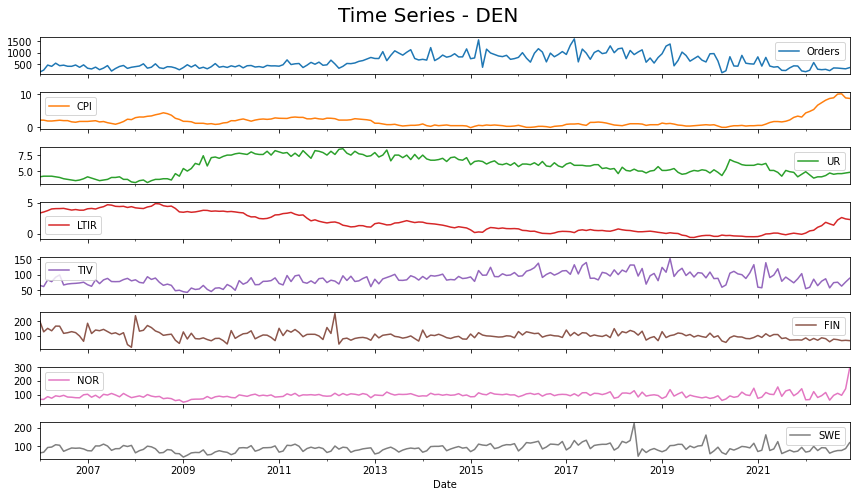

In [11]:
# Plot time series
fig, ax = plt.subplots(figsize=(12, 7))
df.plot(
    legend   = True,
    subplots = True, 
    sharex   = True,
    ax       = ax, 
)
fig.suptitle('Time Series - ' + country, fontsize=20)
fig.tight_layout();

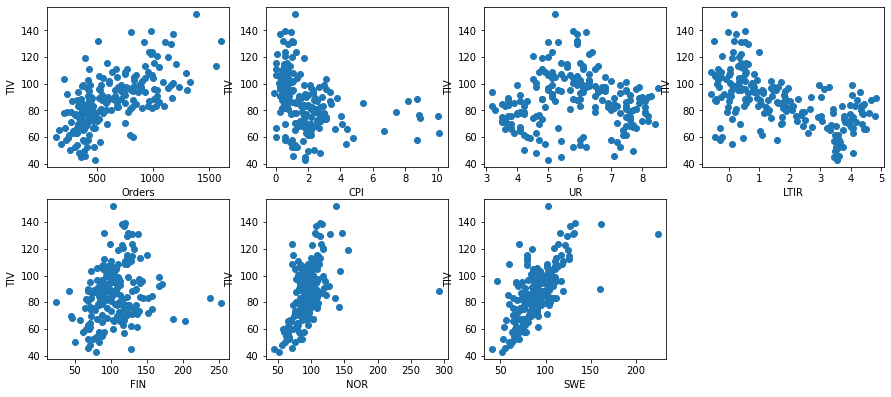

In [12]:
# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):
    
    ind_var = df.loc[:, df.columns != dep_var]  # Independant variables
    figs = len(df.columns) - 1                  # Number of figures 

    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    
    fig = 1
    plt.figure(figsize=(15, 10))
    
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        plt.subplot(num_rows, num_cols, fig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(df,4)

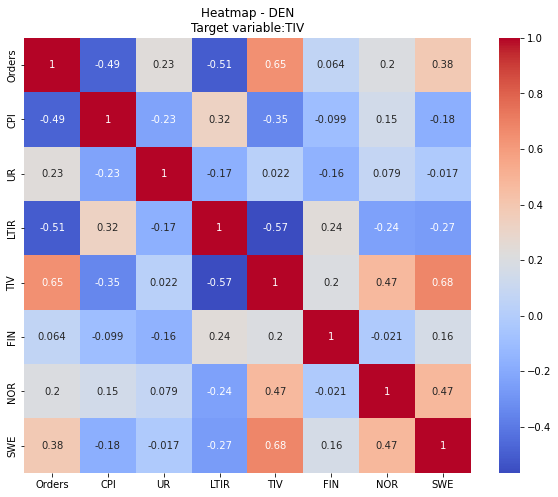

In [13]:
# Plot the correlations as a heatmap
plt.figure(figsize=(10, 8))
ax = plt.axes()
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2g', ax=ax)
ax.set_title('Heatmap - ' + country + '\nTarget variable:'  +dep_var)
plt.show()

### Orders distribution

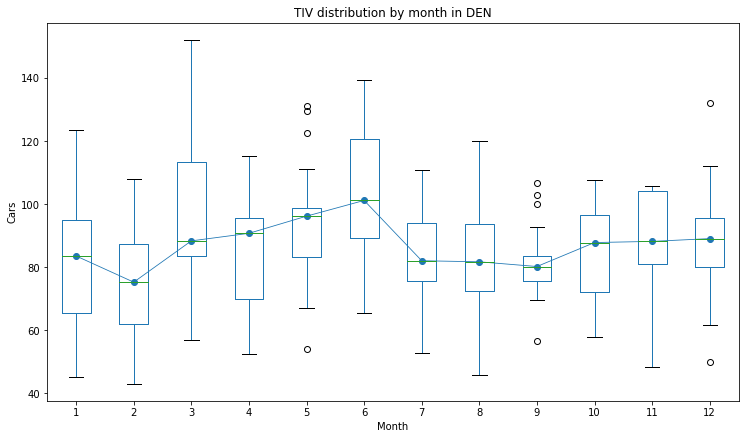

In [14]:
# Boxplot for annual seasonality
fig, ax = plt.subplots(figsize=(12, 7))
df['Month'] = df.index.month
df.boxplot(column=dep_var, by='Month', ax=ax,)
df.groupby('Month')[dep_var].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Cars')
ax.set_title(dep_var + ' distribution by month in ' + country)
fig.suptitle('');
df.drop('Month', axis=1, inplace=True)

### Correlation plots

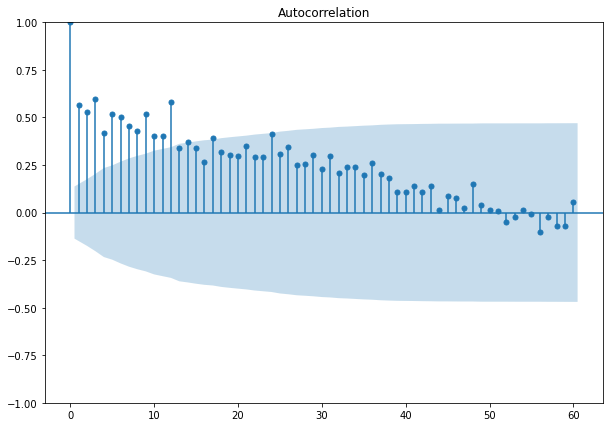

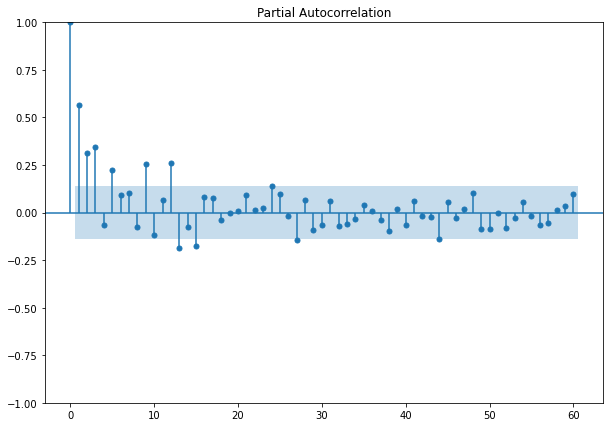

In [15]:
# Autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 7))
plot_acf(df[dep_var], ax=ax, lags=60)

# Partial autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 7))
plot_pacf(df[dep_var], ax=ax, lags=60, method='ywm')
plt.show()

### Trend

Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

We will also include the rolling standard deviation to see how much the data varies from the rolling average.

In [16]:
# Determine rolling statistics
# Wwindow size 12 denotes 12 months, giving rolling mean at yearly level
window_size = 12
df["rolling_avg"] = df[dep_var].rolling(window=window_size).mean() 
df["rolling_std"] = df[dep_var].rolling(window=window_size).std()

title = 'Rolling Mean & Standard Deviation - ' + country

fig= go.Figure()

fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=df[dep_var], mode='lines', name= 'Original')))
fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=df['rolling_avg'], mode='lines', name= 'Rolling Mean')))
fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=df['rolling_std'], mode='lines', name= 'Rolling Std')))

fig.update_layout(height=400, width=1200, title=go.layout.Title(text=title),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))

fig.show()

df.drop(['rolling_avg', 'rolling_std'], axis=1, inplace=True)

### Time series decomposition 

We separate a time series into its components: trend, seasonality, and residuals. The trend represents the slow-moving changes in a time series. It is responsible for making the series gradually increase or decrease over time. The seasonality component represents the seasonal pattern in the series. The cycles occur repeatedly over a fixed period of time. The residuals represent the behavior that cannot be explained by the trend and seasonality components. They correspond to random errors, also termed white noise.

In [17]:
df.columns

Index(['Orders', 'CPI', 'UR', 'LTIR', 'TIV', 'FIN', 'NOR', 'SWE'], dtype='object')

In [18]:
def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition - " + country):
    x_values = dates
    return (
        make_subplots(
            rows=4,
            cols=1,
            shared_xaxes=True,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(go.Scatter(x=x_values.to_timestamp(), y=result.observed, mode="lines", name='Observed'), row=1, col=1,)
        .add_trace(go.Scatter(x=x_values.to_timestamp(), y=result.trend, mode="lines", name='Trend'), row=2, col=1,)
        .add_trace(go.Scatter(x=x_values.to_timestamp(), y=result.seasonal, mode="lines", name='Seasonal'), row=3, col=1,)
        .add_trace(go.Scatter(x=x_values.to_timestamp(), y=result.resid, mode="lines", name='Residual'), row=4, col=1,)
        .update_layout(height=800, width=1000, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False)
        .update_xaxes(dtick="M6",tickformat="%b\n%Y")        
    )

decomposition = seasonal_decompose(df[dep_var], model='multiplicative', period=12)
fig = plot_seasonal_decompose(decomposition, dates=df.index)
fig.show()    

### Stationarity (Augmented Dickey–Fuller Test)

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

* Null Hypothesis: The data is not stationary.

* Alternative Hypothesis: The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

* p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

Results of Dickey-Fuller Test:
Test Statistic                 -1.787
p-value                         0.387
#Lags Used                     14.000
Number of Observations Used   189.000
Critical Value (1%)            -3.465
Critical Value (5%)            -2.877
Critical Value (10%)           -2.575
dtype: float64


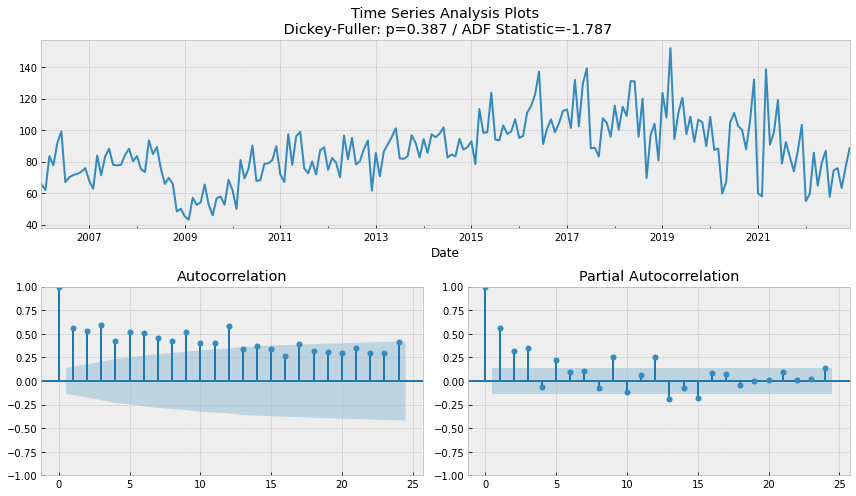

In [19]:
# Time series analysis plot
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        result = adfuller(y, autolag='AIC',regression='c')
        adf = result[0]
        p_value = result[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.3f} / ADF Statistic={1:.3f}'.format(p_value, adf))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()
        
# Data Stationarity check using Augmented Dickey Fuller(ADF) test
def adf_test(timeseries, print_out:bool):    
    dftest = adfuller(timeseries, autolag='AIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if print_out:
        print ('Results of Dickey-Fuller Test:')
        print (dfoutput)    
    return dfoutput['p-value']

tsplot(df[dep_var])

p_value = adf_test(df[dep_var], True)     

Results of Dickey-Fuller Test:
Test Statistic                 -3.730
p-value                         0.004
#Lags Used                     13.000
Number of Observations Used   189.000
Critical Value (1%)            -3.465
Critical Value (5%)            -2.877
Critical Value (10%)           -2.575
dtype: float64


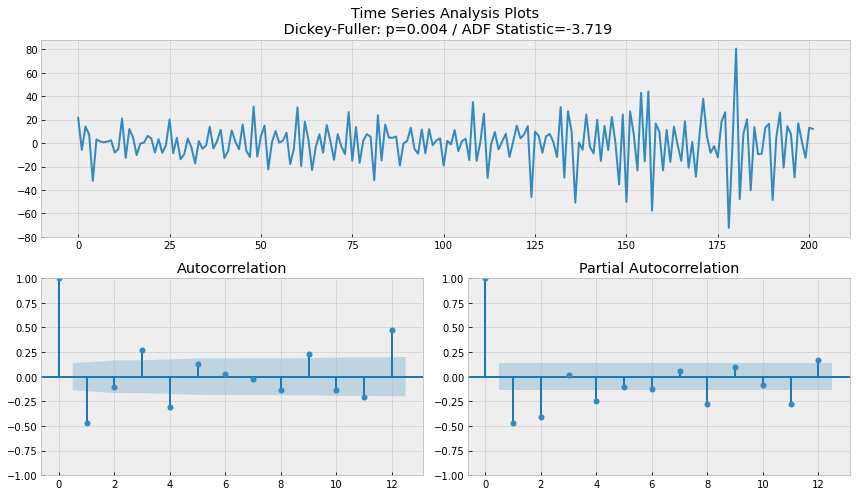

In [20]:
if p_value > 0.05:
    # Take the first difference to make our series stationary    
    data_diff = np.diff(df[dep_var],1)
    tsplot(data_diff[1:], lags=12)
    p_value = adf_test(data_diff, True)  

In [21]:
# Feature selection df
df_fe = df.copy()

### Feature Engineering

In [22]:
# Aply difference 
for c in df_fe.columns:
    p = adf_test(df_fe[c], False)   
    if p > 0.05:
        print(c + ' is not stationary')
        # Apply first difference to stationarize and detrend
        df_fe[c + '_diff'] = df_fe[c].diff(1)
        df_fe.drop([c], axis=1, inplace=True)
        df_fe = df_fe.rename(columns={c + '_diff': c})    
        df_fe.dropna(inplace=True)    
    else:
        print(c + ' is stationary')

Orders is not stationary
CPI is not stationary
UR is not stationary
LTIR is not stationary
TIV is not stationary
FIN is not stationary
NOR is not stationary
SWE is not stationary


In [23]:
# Verify difference 
for c in df_fe.columns:
    p = adf_test(df_fe[c], False)   
    if p > 0.05:
        print(c + ' is not stationary')        
    else:
        print(c + ' is stationary')

Orders is stationary
CPI is stationary
UR is stationary
LTIR is stationary
TIV is stationary
FIN is stationary
NOR is stationary
SWE is stationary


In [24]:
df_fe

,Orders,CPI,UR,LTIR,TIV,FIN,NOR,SWE
Date,,,,,,,,
2006-09,-2.000,-0.369,-0.100,-0.142,1.376,7.289,-1.324,8.504
2006-10,57.000,-0.118,-0.100,0.086,0.720,-6.694,-3.488,-1.479
2006-11,-100.000,0.242,0.100,-0.103,1.254,-23.058,-0.689,1.237
2006-12,106.000,-0.002,0.200,0.002,2.404,-35.762,22.061,-4.963
2007-01,-146.000,0.006,0.300,0.219,-8.025,122.460,4.048,-9.307
...,...,...,...,...,...,...,...,...
2022-08,118.000,0.206,-0.200,-0.211,16.892,17.765,35.364,8.965
2022-09,-6.000,1.109,0.100,0.825,1.324,-3.452,15.201,5.152
2022-10,-15.000,0.093,0.000,0.399,-12.554,-6.650,-14.730,0.574


In [25]:
# Create Lagged target variables 1m to 12m
columns = df_fe.columns.difference([dep_var])
range = np.arange(1,13)
for r in range:
    df_fe[dep_var + '_lag' + str(r)] = df_fe[dep_var].shift(r)    

In [26]:
# Create lagged variables of the exogenoues features
range = [1,3,6,9,12]
for r in range:
    for c in columns:
        df_fe[c + '_lag' + str(r)] = df_fe[dep_var].shift(r)

In [27]:
# Feature engineering - Seasonal patterns
df_fe['Quarter'] = pd.PeriodIndex(df_fe.index, freq='Q').quarter
df_fe['Month'] = pd.PeriodIndex(df_fe.index, freq='M').month
df_fe['Year'] = pd.PeriodIndex(df_fe.index, freq='Y').year

In [28]:
df_fe

,Orders,CPI,UR,LTIR,TIV,FIN,NOR,SWE,TIV_lag1,TIV_lag2,...,CPI_lag12,FIN_lag12,LTIR_lag12,NOR_lag12,Orders_lag12,SWE_lag12,UR_lag12,Quarter,Month,Year
Date,,,,,,,,,,,,,,,,,,,,,
2006-09,-2.000,-0.369,-0.100,-0.142,1.376,7.289,-1.324,8.504,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,9,2006
2006-10,57.000,-0.118,-0.100,0.086,0.720,-6.694,-3.488,-1.479,1.376,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,10,2006
2006-11,-100.000,0.242,0.100,-0.103,1.254,-23.058,-0.689,1.237,0.720,1.376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,11,2006
2006-12,106.000,-0.002,0.200,0.002,2.404,-35.762,22.061,-4.963,1.254,0.720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12,2006
2007-01,-146.000,0.006,0.300,0.219,-8.025,122.460,4.048,-9.307,2.404,1.254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08,118.000,0.206,-0.200,-0.211,16.892,17.765,35.364,8.965,-29.296,7.682,...,13.646,13.646,13.646,13.646,13.646,13.646,13.646,3,8,2022
2022-09,-6.000,1.109,0.100,0.825,1.324,-3.452,15.201,5.152,16.892,-29.296,...,-9.471,-9.471,-9.471,-9.471,-9.471,-9.471,-9.471,3,9,2022
2022-10,-15.000,0.093,0.000,0.399,-12.554,-6.650,-14.730,0.574,1.324,16.892,...,-9.082,-9.082,-9.082,-9.082,-9.082,-9.082,-9.082,4,10,2022


In [29]:
df_fe = df_fe.dropna()

### Feature Selection

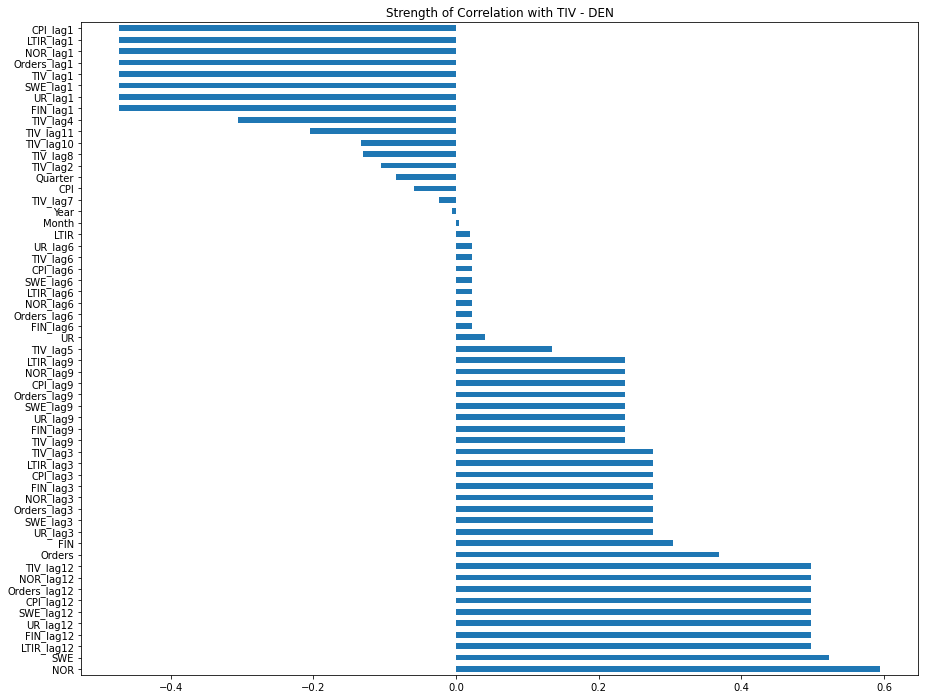

In [30]:
figure(figsize=(15, 12))

corr = df_fe.loc[:, df_fe.columns != dep_var].corrwith(df_fe[dep_var])
corr.sort_values(ascending=False).plot.barh(title = 'Strength of Correlation with ' + dep_var + ' - ' + country);

In [31]:
#Correlation with output variable using Pearson Correlation
threshold = 0.4
cor = df_fe.corr()
cor_target = abs(cor[dep_var])

#Selecting highly correlated features
relevant_features = cor_target[(cor_target > threshold)].to_frame()
relevant_features.sort_values(by=dep_var, ascending=False)

,TIV
TIV,1.000
NOR,0.594
SWE,0.523
SWE_lag12,0.498
Orders_lag12,0.498
NOR_lag12,0.498
LTIR_lag12,0.498
FIN_lag12,0.498
CPI_lag12,0.498
UR_lag12,0.498


In [32]:
# Keep only meaningful features
df_fe = df_fe[relevant_features.index]

In [33]:
df_fe

,TIV,NOR,SWE,TIV_lag1,TIV_lag12,CPI_lag1,FIN_lag1,LTIR_lag1,NOR_lag1,Orders_lag1,SWE_lag1,UR_lag1,CPI_lag12,FIN_lag12,LTIR_lag12,NOR_lag12,Orders_lag12,SWE_lag12,UR_lag12
Date,,,,,,,,,,,,,,,,,,,
2007-09,0.424,-13.447,0.408,-0.389,1.376,-0.389,-0.389,-0.389,-0.389,-0.389,-0.389,-0.389,1.376,1.376,1.376,1.376,1.376,1.376,1.376
2007-10,6.184,24.518,17.005,0.424,0.720,0.424,0.424,0.424,0.424,0.424,0.424,0.424,0.720,0.720,0.720,0.720,0.720,0.720,0.720
2007-11,3.972,-16.511,-5.418,6.184,1.254,6.184,6.184,6.184,6.184,6.184,6.184,6.184,1.254,1.254,1.254,1.254,1.254,1.254,1.254
2007-12,-7.996,-14.334,5.932,3.972,2.404,3.972,3.972,3.972,3.972,3.972,3.972,3.972,2.404,2.404,2.404,2.404,2.404,2.404,2.404
2008-01,3.368,6.041,-40.208,-7.996,-8.025,-7.996,-7.996,-7.996,-7.996,-7.996,-7.996,-7.996,-8.025,-8.025,-8.025,-8.025,-8.025,-8.025,-8.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08,16.892,35.364,8.965,-29.296,13.646,-29.296,-29.296,-29.296,-29.296,-29.296,-29.296,-29.296,13.646,13.646,13.646,13.646,13.646,13.646,13.646
2022-09,1.324,15.201,5.152,16.892,-9.471,16.892,16.892,16.892,16.892,16.892,16.892,16.892,-9.471,-9.471,-9.471,-9.471,-9.471,-9.471,-9.471
2022-10,-12.554,-14.730,0.574,1.324,-9.082,1.324,1.324,1.324,1.324,1.324,1.324,1.324,-9.082,-9.082,-9.082,-9.082,-9.082,-9.082,-9.082


In [34]:
if feature_selection:
    df = df_fe.copy()

In [35]:
df

,TIV,NOR,SWE,TIV_lag1,TIV_lag12,CPI_lag1,FIN_lag1,LTIR_lag1,NOR_lag1,Orders_lag1,SWE_lag1,UR_lag1,CPI_lag12,FIN_lag12,LTIR_lag12,NOR_lag12,Orders_lag12,SWE_lag12,UR_lag12
Date,,,,,,,,,,,,,,,,,,,
2007-09,0.424,-13.447,0.408,-0.389,1.376,-0.389,-0.389,-0.389,-0.389,-0.389,-0.389,-0.389,1.376,1.376,1.376,1.376,1.376,1.376,1.376
2007-10,6.184,24.518,17.005,0.424,0.720,0.424,0.424,0.424,0.424,0.424,0.424,0.424,0.720,0.720,0.720,0.720,0.720,0.720,0.720
2007-11,3.972,-16.511,-5.418,6.184,1.254,6.184,6.184,6.184,6.184,6.184,6.184,6.184,1.254,1.254,1.254,1.254,1.254,1.254,1.254
2007-12,-7.996,-14.334,5.932,3.972,2.404,3.972,3.972,3.972,3.972,3.972,3.972,3.972,2.404,2.404,2.404,2.404,2.404,2.404,2.404
2008-01,3.368,6.041,-40.208,-7.996,-8.025,-7.996,-7.996,-7.996,-7.996,-7.996,-7.996,-7.996,-8.025,-8.025,-8.025,-8.025,-8.025,-8.025,-8.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08,16.892,35.364,8.965,-29.296,13.646,-29.296,-29.296,-29.296,-29.296,-29.296,-29.296,-29.296,13.646,13.646,13.646,13.646,13.646,13.646,13.646
2022-09,1.324,15.201,5.152,16.892,-9.471,16.892,16.892,16.892,16.892,16.892,16.892,16.892,-9.471,-9.471,-9.471,-9.471,-9.471,-9.471,-9.471
2022-10,-12.554,-14.730,0.574,1.324,-9.082,1.324,1.324,1.324,1.324,1.324,1.324,1.324,-9.082,-9.082,-9.082,-9.082,-9.082,-9.082,-9.082


### Split Data

In [36]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

print('\nData shape:', train.shape, test.shape)

# Select input and target variables
X_train = train.drop(dep_var, axis=1)
y_train = train[dep_var]

X_test = test.drop(dep_var, axis=1)
y_test = test[dep_var]

print('\nTrain shape:', X_train.shape, y_train.shape)
print('\nTest shape:', X_test.shape, y_test.shape)

Dataset length : (n=184)
Train dates    : 2007-09 --- 2019-12  (n=148)
Test dates     : 2020-01 --- 2022-12  (n=36)

Data shape: (148, 19) (36, 19)

Train shape: (148, 18) (148,)

Test shape: (36, 18) (36,)


### Scoring Function

In [37]:
# Function to revert the first differencing
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        #print(df_train[col].iloc[-1])
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [38]:
metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred, dataframe, print_metrics: bool, plot_results: bool):

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy
        
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        # Plot only test set
        fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
                
        # Plot whole data                
        #fig.add_trace(go.Scatter(dict(x=train.index.to_timestamp(), y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)   
        fig.add_trace(go.Scatter(dict(x=train.index.to_timestamp(), y=dataframe[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)   
        fig.add_trace(go.Scatter(dict(x=test.index.to_timestamp(), y=y_true, mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index.to_timestamp(), y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions (Country: " + country + ' - Target variable: ' + dep_var + ')')    

        fig.show()         

In [100]:
def plot_metrics(m, w, h):
    chart = m.transpose()
    chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

    ax = chart.plot.barh(title="Models Performance (" + country + ' /  ' + dep_var + ')\nFeature Engineering:' + str(feature_selection) + ' / Include Nordics: ' + str(include_nordics), figsize=(w, h))
    for c in ax.containers:        
        ax.bar_label(c, fmt='%0.2f', label_type='edge', padding=5)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

In [101]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree
Mean Absolute Error,18.438,19.831,42.359,18.272,19.771,18.636,26.768
Mean Squared Error,575.023,650.213,"2,351.959",493.294,546.812,635.954,"1,062.530"
Root Mean Squared Error,23.980,25.499,48.497,22.210,23.384,25.218,32.596
R^2,-0.340,-0.515,-4.481,-0.150,-0.274,-0.482,-1.476
Mean Absolute Percentage Error,24.708,26.464,55.588,24.469,26.394,24.868,35.235
Accuracy,75.292,73.536,44.412,75.531,73.606,75.132,64.765


### ML Models

In [102]:
# Hyperparameters
modelclasses = [
    ["Extra Tree", ExtraTreesRegressor],
    ["XGBoost", XGBRegressor],
    ["Gradient Boosting", GradientBoostingRegressor],
    ["Random Forest", RandomForestRegressor],
    ["Ada Boost", AdaBoostRegressor],
    ["LightGBM", LGBMRegressor],
    ["Decision Tree", DecisionTreeRegressor]
]

for model_name, Model in modelclasses:
    
    # Instantiate the model
    model = Model()
    
    # Fit 
    model.fit(X_train,y_train)
        
    # Predict
    y_pred = model.predict(X_test) 

    if feature_selection:

        # Create dataframe of predictions
        y_pred_df = pd.DataFrame(data=y_pred, index=test.index, columns=[dep_var])

        # Invert transformation
        y_pred_df_inv = invert_transformation(df_original[[dep_var]].iloc[:-steps],y_pred_df)

        # Score
        scoring(model_name, df_original[[dep_var]].iloc[-steps:].squeeze(), y_pred_df_inv[dep_var + '_forecast'].values, df_original, True, True)

    else:

        # Score
        scoring(model_name, y_test, y_pred, df, True, True)

Extra Tree Model Performance:
Mean Absolute Error: 18.39.
Mean Squared Error: 508.32.
Root Mean Squared Error: 22.55.
R^2 Score = -0.18.
Mean Absolute Percentage Error: 24.25%.
Accuracy = 75.75%.


XGBoost Model Performance:
Mean Absolute Error: 19.83.
Mean Squared Error: 650.21.
Root Mean Squared Error: 25.50.
R^2 Score = -0.52.
Mean Absolute Percentage Error: 26.46%.
Accuracy = 73.54%.


Gradient Boosting Model Performance:
Mean Absolute Error: 40.69.
Mean Squared Error: 2183.60.
Root Mean Squared Error: 46.73.
R^2 Score = -4.09.
Mean Absolute Percentage Error: 53.36%.
Accuracy = 46.64%.


Random Forest Model Performance:
Mean Absolute Error: 18.49.
Mean Squared Error: 506.13.
Root Mean Squared Error: 22.50.
R^2 Score = -0.18.
Mean Absolute Percentage Error: 24.72%.
Accuracy = 75.28%.


Ada Boost Model Performance:
Mean Absolute Error: 21.94.
Mean Squared Error: 735.57.
Root Mean Squared Error: 27.12.
R^2 Score = -0.71.
Mean Absolute Percentage Error: 28.59%.
Accuracy = 71.41%.


LightGBM Model Performance:
Mean Absolute Error: 18.64.
Mean Squared Error: 635.95.
Root Mean Squared Error: 25.22.
R^2 Score = -0.48.
Mean Absolute Percentage Error: 24.87%.
Accuracy = 75.13%.


Decision Tree Model Performance:
Mean Absolute Error: 28.41.
Mean Squared Error: 1226.55.
Root Mean Squared Error: 35.02.
R^2 Score = -1.86.
Mean Absolute Percentage Error: 37.42%.
Accuracy = 62.58%.


In [103]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date")
df.index = pd.PeriodIndex(df.index, freq="M")

# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

df_forecast=pd.DataFrame(data=y_pred, index=test.index, columns=[dep_var])
df_inv = invert_transformation(train[[dep_var]], df_forecast)
df_inv.insert(2, "Original", test[[dep_var]])
df_inv

,TIV,TIV_forecast,Original
Date,,,
2020-01,-1.939,87.898,108.472
2020-02,-15.243,72.655,87.434
2020-03,11.236,83.892,88.363
2020-04,-35.277,48.615,59.724
2020-05,42.919,91.534,67.046
2020-06,14.895,106.428,104.802
2020-07,-15.168,91.261,110.923
2020-08,14.895,106.155,102.642
2020-09,13.966,120.121,100.058


In [104]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree
Mean Absolute Error,18.385,19.831,40.693,18.491,21.937,18.636,28.414
Mean Squared Error,508.318,650.213,"2,183.604",506.127,735.574,635.954,"1,226.550"
Root Mean Squared Error,22.546,25.499,46.729,22.497,27.121,25.218,35.022
R^2,-0.185,-0.515,-4.089,-0.179,-0.714,-0.482,-1.858
Mean Absolute Percentage Error,24.246,26.464,53.358,24.724,28.592,24.868,37.419
Accuracy,75.754,73.536,46.642,75.276,71.408,75.132,62.581


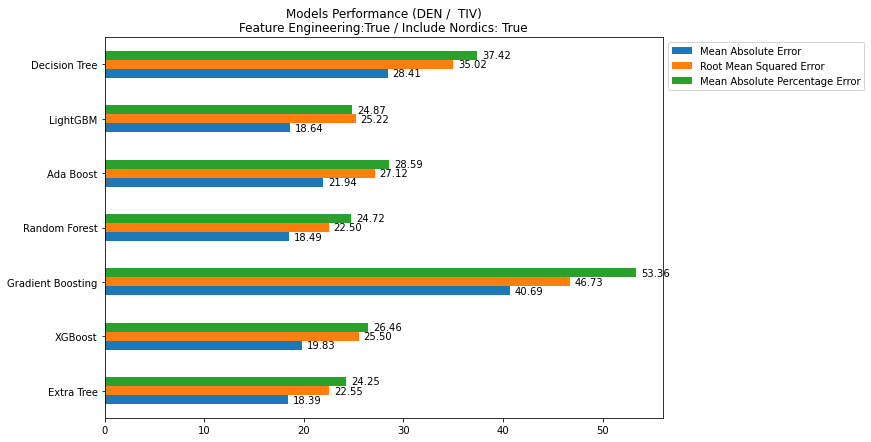

In [105]:
plot_metrics(metrics, 10, 7)

### Statistical Models

In [ ]:
start=len(train)
end=len(train)+len(test)-1

In [ ]:
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date")
df.index = pd.PeriodIndex(df.index, freq="M")

# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

print('\nData shape:', train.shape, test.shape)

# Select input and target variables
X_train = train.drop(dep_var, axis=1)
y_train = train[dep_var]

X_test = test.drop(dep_var, axis=1)
y_test = test[dep_var]

print('\nTrain shape:', X_train.shape, y_train.shape)
print('\nTest shape:', X_test.shape, y_test.shape)

Dataset length : (n=204)
Train dates    : 2006-01 --- 2019-12  (n=168)
Test dates     : 2020-01 --- 2022-12  (n=36)

Data shape: (168, 5) (36, 5)

Train shape: (168, 4) (168,)

Test shape: (36, 4) (36,)


#### Simple Exponential Smoothing

In [ ]:
model_name='Simple Exponential Smoothing'
span = 12
alpha = 2/(span+1)

# Train
model = SimpleExpSmoothing(train[dep_var]).fit(smoothing_level=alpha,optimized=False)

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
scoring(model_name, test[dep_var], predictions, df, True, True)

Simple Exponential Smoothing Model Performance:
Mean Absolute Error: 22.72.
Mean Squared Error: 736.20.
Root Mean Squared Error: 27.13.
R^2 Score = -0.72.
Mean Absolute Percentage Error: 31.43%.
Accuracy = 68.57%.


#### Double Exponential Smoothing

In [ ]:
model_name='Double Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal_periods=12).fit()
# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
scoring(model_name, test[dep_var], predictions, df, True, True)

Double Exponential Smoothing Model Performance:
Mean Absolute Error: 24.46.
Mean Squared Error: 837.06.
Root Mean Squared Error: 28.93.
R^2 Score = -0.95.
Mean Absolute Percentage Error: 33.82%.
Accuracy = 66.18%.


#### Triple Exponential Smoothing

In [ ]:
model_name='Triple Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal='add',seasonal_periods=12).fit()

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
scoring(model_name, test[dep_var], predictions, df, True, True)

Triple Exponential Smoothing Model Performance:
Mean Absolute Error: 25.06.
Mean Squared Error: 858.16.
Root Mean Squared Error: 29.29.
R^2 Score = -1.00.
Mean Absolute Percentage Error: 34.28%.
Accuracy = 65.72%.


In [ ]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing
Mean Absolute Error,18.30,19.83,43.90,19.74,18.66,18.64,37.46,22.72,24.46,25.06
Mean Squared Error,552.47,650.21,"2,510.92",611.85,520.88,635.95,"2,409.40",736.20,837.06,858.16
Root Mean Squared Error,23.50,25.50,50.11,24.74,22.82,25.22,49.09,27.13,28.93,29.29
R^2,-0.29,-0.52,-4.85,-0.43,-0.21,-0.48,-4.61,-0.72,-0.95,-1.00
Mean Absolute Percentage Error,24.47,26.46,57.57,25.93,24.87,24.87,50.32,31.43,33.82,34.28
Accuracy,75.53,73.54,42.43,74.07,75.13,75.13,49.68,68.57,66.18,65.72


#### ARIMA

In [ ]:
#Standard ARIMA Model
model = auto_arima(train[dep_var], 
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=1,                        # Frequency of series (if m==1, seasonal is set to FALSE automatically)
                    d=None,                     # Let model determine 'd'
                    seasonal=False,             # No Seasonality for standard ARIMA
                    trace=True,                 # Logs 
                    error_action= 'warn',       # Shows errors ('ignore' silences these)
                    suppress_warnings=True,
                    stepwise=True)       

model_name='ARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
scoring(model_name, test[dep_var], predictions, df, True, True)                                

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1350.790, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1990.537, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1420.659, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1802.877, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1352.782, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1352.784, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1742.687, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1351.158, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1347.468, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1435.540, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1390.179, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1349.432, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1349.445, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : 

#### SARIMA

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
model = auto_arima(train[dep_var],
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=12,                       # Frequency of series (if m==1, seasonal is set to FALSE automatically) - 12 months
                    start_P=0, 
                    seasonal=True,              # set to seasonal
                    d=None,                     # Let model determine 'd'
                    D=1,                        # Order of the seasonal differencing
                    trace=True,                 # Logs 
                    error_action='warn',        # Shows errors ('ignore' silences these)
                    suppress_warnings=True, 
                    stepwise=True)  

model_name='SARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
scoring(model_name, test[dep_var], predictions, df, True, True)                    

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1185.358, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1283.283, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1223.887, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1186.049, Time=0.16 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1223.179, Time=0.05 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1185.652, Time=0.41 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1185.678, Time=0.75 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1203.274, Time=0.16 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1187.620, Time=1.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1204.471, Time=0.15 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1183.283, Time=0.31 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1220.804, Time=0.07 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1184.284, Time=0.61 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1184.372, Time=1.07 sec
 ARIMA(2,1,1)(1,1,0

#### SARIMAX

In [ ]:
train.loc[:, train.columns != dep_var]

,Orders,CPI,UR,LTIR
Date,,,,
2006-01,161,2.18,4.10,3.31
2006-02,250,2.16,4.20,3.48
2006-03,468,1.91,4.20,3.70
2006-04,412,1.90,4.20,3.98
2006-05,550,2.02,4.10,4.02
...,...,...,...,...
2019-08,637,0.39,4.90,-0.58
2019-09,744,0.49,5.10,-0.59
2019-10,853,0.58,5.00,-0.43


In [ ]:
# SARIMAX = SARIMA with exogenous variable
exo_train = train.loc[:, train.columns != dep_var]
exo_test = test.loc[:, test.columns != dep_var]
model = auto_arima(train[dep_var], exogenous=exo_train,
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

model_name='SARIMAX'

# Predict
predictions = model.predict(n_periods=test.shape[0], exog=exo_test,  dynamic=False, typ='levels')

# Forecast accuracy
scoring(model_name, test[dep_var], predictions, df, True, True)                           

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1185.358, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1283.283, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1223.887, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1186.049, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1223.179, Time=0.05 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1185.652, Time=0.42 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1185.678, Time=0.73 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1203.274, Time=0.15 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1187.620, Time=1.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1204.471, Time=0.14 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1183.283, Time=0.31 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1220.804, Time=0.07 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1184.284, Time=0.61 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1184.372, Time=1.03 sec
 ARIMA(2,1,1)(1,1,0

### Results

In [ ]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA,SARIMA,SARIMAX
Mean Absolute Error,18.30,19.83,43.90,19.74,18.66,18.64,37.46,22.72,24.46,25.06,18.19,25.71,25.71
Mean Squared Error,552.47,650.21,"2,510.92",611.85,520.88,635.95,"2,409.40",736.20,837.06,858.16,492.57,921.50,921.50
Root Mean Squared Error,23.50,25.50,50.11,24.74,22.82,25.22,49.09,27.13,28.93,29.29,22.19,30.36,30.36
R^2,-0.29,-0.52,-4.85,-0.43,-0.21,-0.48,-4.61,-0.72,-0.95,-1.00,-0.15,-1.15,-1.15
Mean Absolute Percentage Error,24.47,26.46,57.57,25.93,24.87,24.87,50.32,31.43,33.82,34.28,24.48,35.05,35.05
Accuracy,75.53,73.54,42.43,74.07,75.13,75.13,49.68,68.57,66.18,65.72,75.52,64.95,64.95


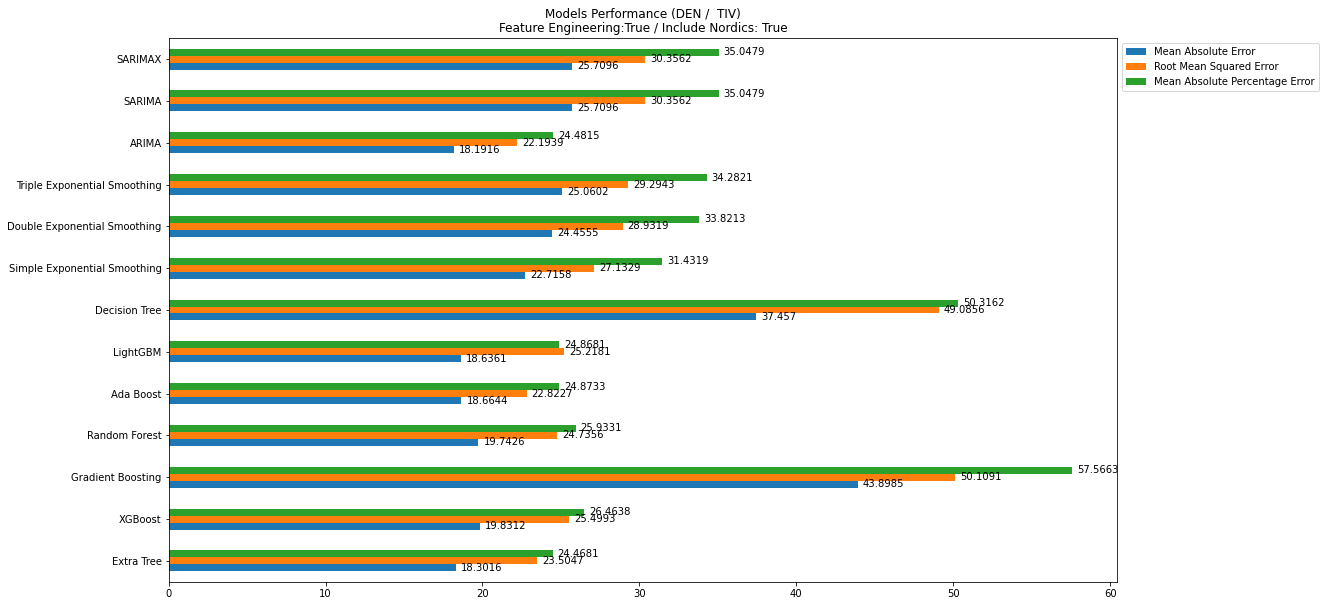

In [ ]:
plot_metrics(metrics, 17, 10, 'barh')